In [1]:
import pandas as pd
import os
from pysam import VariantFile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats  as stats

plt.style.use('aa_paper')
%matplotlib inline

In [2]:
cas_dict={
    'SpCas9':'SpCas9',
    'SpCas9_VRER':'SpCas9-V1',
    'SpCas9_EQR':'SpCas9-V2',
    'SpCas9_VQR':'SpCas9-V3',
    'SpCas9_VQR_1':'SpCas9-V3',
    'SpCas9_VQR_2':'SpCas9-V3',
    'StCas9_1':'StCas9-V1',
    'StCas9_2':'StCas9-V2',
    'SaCas9':'SaCas9',
    'SaCas9_KKH':'SaCas9-V1',
    'nmCas9':'nmCas9',
    'cpf1':'cpf1',
    'StCas9_1':'StCas9-V1',
    'StCas9_2':'StCas9-V2',
    'cjCas9':'cjCas9'
}

In [20]:
# ExAc (hg19)

plotdf_exac = pd.read_csv('../exac_analysis/dat/vars_near_in_df.tsv', sep='\t',
                    header=0, names=['cas','in PAM','near PAM','both'])

plotdf_1kgp = pd.read_csv('../1000genomes_analysis/dat/vars_near_in_df.tsv', sep='\t',
                    header=0, names=['cas','in PAM','near PAM','both'])

#sort by total variants that generate allele-specific PAM site
plotdf_exac['total'] = plotdf_exac[['in PAM','near PAM','both']].sum(axis=1)
plotdf_exac['Cas'] = plotdf_exac['cas'].replace(cas_dict)
plotdf_exac = plotdf_exac.query('total > 0.0')

plotdf_1kgp['total'] = plotdf_1kgp[['in PAM','near PAM','both']].sum(axis=1)
plotdf_1kgp['Cas'] = plotdf_1kgp['cas'].replace(cas_dict)
plotdf_1kgp = plotdf_1kgp.query('total > 0.0')

# munge for plotting
plotdf_exac = plotdf_exac.sort_values(by='total')
plotdf_exac.index = plotdf_exac['Cas']
plotdf_exac = plotdf_exac[['both','in PAM','near PAM']]
plotdf_exac = plotdf_exac.multiply(100.0)

plotdf_1kgp = plotdf_1kgp.sort_values(by='total')
plotdf_1kgp.index = plotdf_1kgp['Cas']
plotdf_1kgp = plotdf_1kgp[['both','in PAM','near PAM']]
plotdf_1kgp = plotdf_1kgp.multiply(100.0)

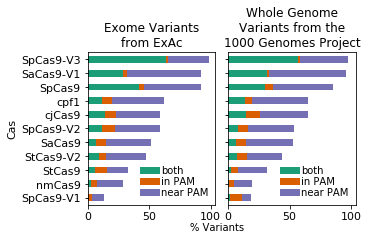

In [23]:
# assemble plot 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,
                        sharex=True)
plt.subplots_adjust(wspace=0.1)

exac_plot = plotdf_exac.plot(stacked='True', color=sns.color_palette('Dark2'),
            kind='barh',ax=ax1, title='Exome Variants\nfrom ExAc')
ax1.legend(handletextpad=0.1, borderpad=0.2, frameon=False,
          labelspacing=0.1)

kgp_plot = plotdf_1kgp.plot(stacked='True', color=sns.color_palette('Dark2'),
            kind='barh',ax=ax2,
                 title='Whole Genome\nVariants from the\n1000 Genomes Project')
ax2.legend(handletextpad=0.1, borderpad=0.2, frameon=False,
          labelspacing=0.1)

fig.text(0.5, 0.00, '% Variants', ha='center')
fig.set_size_inches(4.8,2.8)
plt.savefig('exac_1kgp_variant_categories.pdf', dpi=300, bbox_inches='tight')

# Evaluate likelihood that a variant impacts a PAM site

In [19]:
plotdf_1kgp.sum(axis=1).max()

97.937331141855893

In [20]:
plotdf_exac.sum(axis=1).max()

98.869456811541681

# Correlation of likelihood of variant to impact PAM site with PAM frequency in reference genome

In [53]:
cas_dict = np.load('/pollard/data/projects/AlleleAnalyzer_data/cas_abbrev_dict.npy').item()

del cas_dict['StCas9']
cas_dict['StCas9'] = 'StCas9'

In [55]:
pam_presence_dict

{'SaCas9': 81995513,
 'SaCas9_KKH': 377660720,
 'SpCas9': 298215692,
 'SpCas9_EQR': 96335412,
 'SpCas9_VQR': 610826829,
 'SpCas9_VQR_1': 0,
 'SpCas9_VQR_2': 0,
 'SpCas9_VRER': 13621250,
 'StCas9': 44842077,
 'StCas9_2': 73084178,
 'cjCas9': 115415889,
 'cpf1': 219915585,
 'nmCas9': 23337243}

In [5]:
pam_sizes = {'SpCas9':2, 'SpCas9-V1':3, 'SpCas9-V2':3, 'SpCas9-V3':2, 
             'SaCas9':4, 'SaCas9-V1':3, 'nmCas9':4, 'cpf1':3, 
             'StCas9':4, 'StCas9-V2':4, 'cjCas9':3}

# cas_dict = np.load('/pollard/data/projects/AlleleAnalyzer_data/cas_abbrev_dict.npy').item()

pam_presence_dict = np.load('/pollard/data/projects/AlleleAnalyzer_data/pam_sites_hg19/n_pams_per_cas.npy').item()
pam_presence_df = pd.DataFrame.from_dict(pam_presence_dict, orient='index')
pam_presence_df.columns = ['n_occurrences']
pam_presence_df['Cas'] = pam_presence_df.index
cas_list = list(pam_sizes.keys())
pam_presence_df = pam_presence_df.replace(cas_dict)
pam_presence_df['in_list'] = pam_presence_df['Cas'].isin(cas_list)
pam_presence_df = pam_presence_df.query('in_list')[['n_occurrences','Cas']]
pam_presence_df['PAM_size'] = pam_presence_df.apply(lambda row: pam_sizes[row['Cas']], axis=1)

pam_presence_df.sort_values(by='n_occurrences', ascending=False)

,n_occurrences,Cas,PAM_size
SpCas9_VQR,610826829,SpCas9-V3,2
SaCas9_KKH,377660720,SaCas9-V1,3
SpCas9,298215692,SpCas9,2
cpf1,219915585,cpf1,3
cjCas9,115415889,cjCas9,3
SpCas9_EQR,96335412,SpCas9-V2,3
SaCas9,81995513,SaCas9,4
StCas9_2,73084178,StCas9-V2,4
StCas9,44842077,StCas9,4
nmCas9,23337243,nmCas9,4


In [11]:
plotdf_exac['dset'] = 'exac'
plotdf_1kgp['dset'] = 'kgp'
plotdf_overall = pd.concat([plotdf_exac, plotdf_1kgp])
plotdf_overall['total'] = plotdf_overall.sum(axis=1)

In [12]:
plotdf_overall['total'].min()

13.17283806219285

In [13]:
plotdf_1kgp['total'] = plotdf_1kgp.sum(axis=1)
plotdf_1kgp = plotdf_1kgp.merge(pam_presence_df, on='Cas')

In [14]:
plotdf_1kgp['total'].min()

18.461986055483266

In [15]:
plotdf_1kgp['total'].max()

97.937331141855893

In [68]:
stats.pearsonr(plotdf_1kgp['total'].tolist(), plotdf_1kgp['n_occurrences'].tolist())

(0.89263786347248619, 0.00021782655352897354)

In [74]:
stats.pearsonr(plotdf_1kgp['total'].tolist(), plotdf_1kgp['PAM_size'].tolist())

(-0.7115439747097041, 0.014063135942654544)

In [21]:
plotdf_exac['total'] = plotdf_exac.sum(axis=1)
plotdf_exac = plotdf_exac.merge(pam_presence_df, on='Cas')

In [22]:
plotdf_exac['total'].min()

13.17283806219285

In [23]:
plotdf_exac['total'].max()

98.869456811541681

In [71]:
stats.pearsonr(plotdf_exac['total'].tolist(), plotdf_exac['n_occurrences'].tolist())

(0.84481184670874587, 0.0010638452040013535)

In [73]:
stats.pearsonr(plotdf_exac['total'].tolist(), plotdf_exac['PAM_size'].tolist())

(-0.73908080652945396, 0.009355197023261385)